# Dark Gatekeeper

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import pyvisa as visa
import pandas as pd
from tqdm import tqdm
import time
import os

In [109]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'

In [ ]:
%run "../setup/Setup_Generic.ipynb"

INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer😍


In [ ]:
cw.program_target(scope, prog, "darkGatekeeper-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5603 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5603 bytes


## Capture and Save Power Traces

In [ ]:
folder = "./Traces/darkerkeeper/"  # Change this to your desired folder

if not os.path.exists(folder):
    print("folder done")
    os.makedirs(folder)


In [117]:

flag_length = 12

plaintexts = []
power_traces = []

for i in range(256):

    # Define empty array to store the recovered flag characters
    flag_guess = bytes([i])* flag_length
    print(f"Flag Guess: {flag_guess}")
    plaintexts.append(bytes([i]))

    # Arm the Chipwhisper
    scope.arm()

    target.simpleserial_write('a', flag_guess)

    # Capture the power trace
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    # Read the device response
    response = target.simpleserial_read('r', 18)

    if response is not None:
        print(response)

    # Read the power trace from the ChipWhisperer Nano
    power_trace = scope.get_last_trace()

    # Append the power trace to the list of power traces
    power_traces.append(power_trace)

traces = np.array(power_traces)
data = {'power_traces': traces, "plaintexts":plaintexts}

np.savez("/home/ssanjaya/Desktop/SCA_Comp/csaw_esc_2025/challenges/set1/Traces/darkerkeeper/power_traces_and_plaintexts.npz", **data)

Flag Guess: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
bytearray(b'Access Denied.....')
Flag Guess: b'\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01'
bytearray(b'Access Denied.....')
Flag Guess: b'\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02'
bytearray(b'Access Denied.....')
Flag Guess: b'\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03'
bytearray(b'Access Denied.....')
Flag Guess: b'\x04\x04\x04\x04\x04\x04\x04\x04\x04\x04\x04\x04'
bytearray(b'Access Denied.....')
Flag Guess: b'\x05\x05\x05\x05\x05\x05\x05\x05\x05\x05\x05\x05'
bytearray(b'Access Denied.....')
Flag Guess: b'\x06\x06\x06\x06\x06\x06\x06\x06\x06\x06\x06\x06'
bytearray(b'Access Denied.....')
Flag Guess: b'\x07\x07\x07\x07\x07\x07\x07\x07\x07\x07\x07\x07'
bytearray(b'Access Denied.....')
Flag Guess: b'\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08'
bytearray(b'Access Denied.....')
Flag Guess: b'\t\t\t\t\t\t\t\t\t\t\t\t'
bytearray(b'Access Denied.....')
Flag Guess: b'\n\n\n\n\n\n\n\n\n\n\n\n'
bytearray(b'Ac

## Attack

✅ Data loaded successfully from '/home/ssanjaya/Desktop/SCA_Comp/csaw_esc_2025/challenges/set1/Traces/darkerkeeper/power_traces_and_plaintexts.npz'.
Found 256 traces to visualize.
227


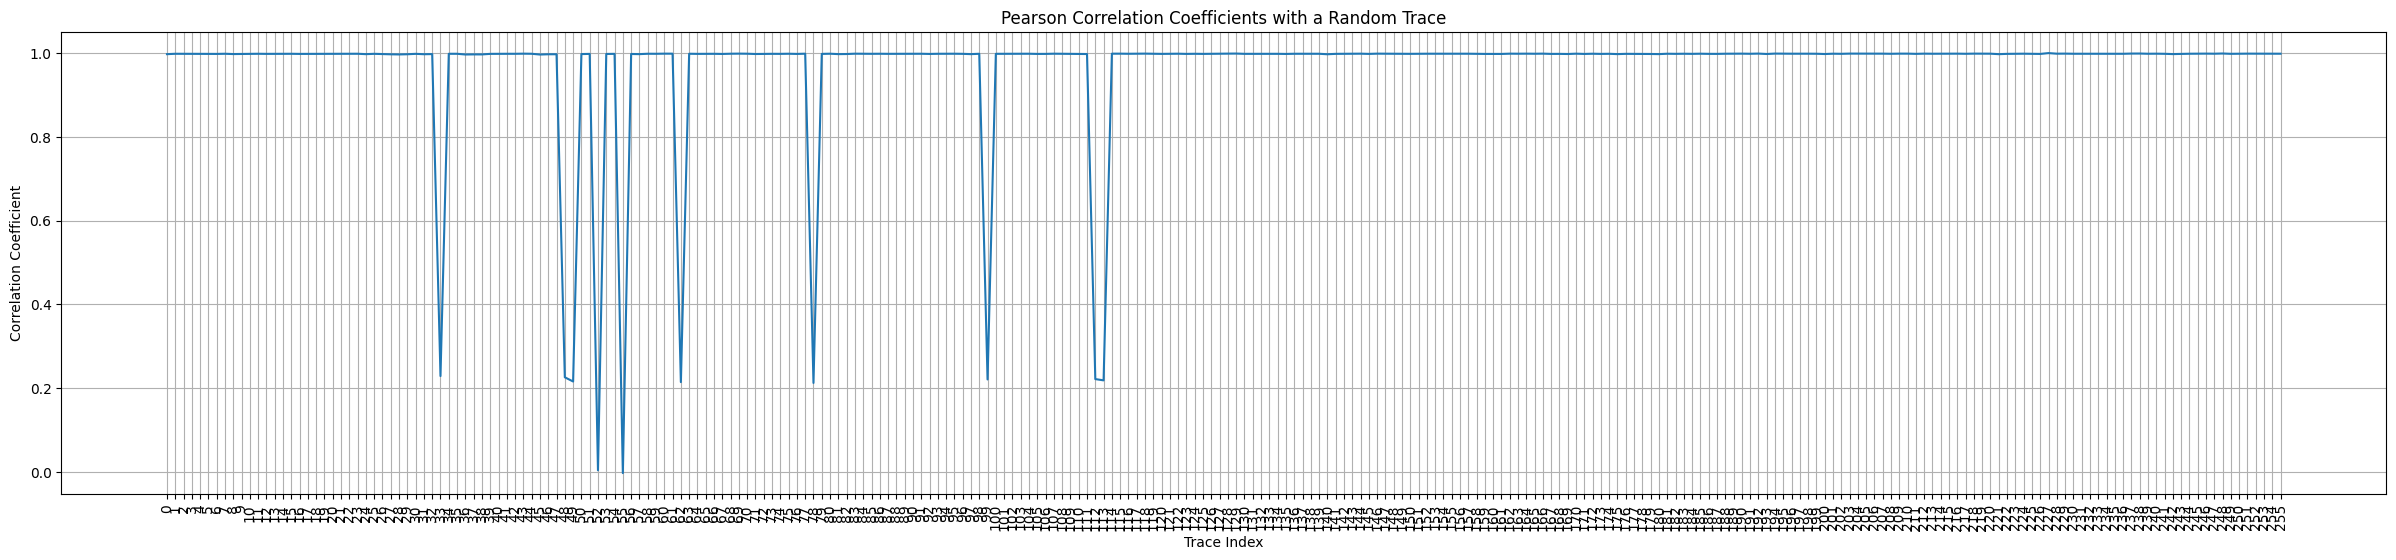

In [213]:

try:
    input_file = '/home/ssanjaya/Desktop/SCA_Comp/csaw_esc_2025/challenges/set1/Traces/darkerkeeper/power_traces_and_plaintexts.npz'
    data = np.load(input_file)
except FileNotFoundError:
    print(f"Error: File not found at '{input_file}'.")
    print("Make sure you run the capture and save script first.")
    exit()

loaded_traces = data['power_traces']
loaded_plaintexts = data['plaintexts']

print(f"✅ Data loaded successfully from '{input_file}'.")
print(f"Found {len(loaded_traces)} traces to visualize.")
cropped_traces = []
for i in range(256): # len(loaded_traces)
    trace = loaded_traces[i]
    # plaintext = loaded_plaintexts[i]
    # tested_char = loaded_plaintexts[i]

    cropped_traces.append(trace[0:5000])
    # tested_char = chr(tested_char[0])

    # plt.figure(figsize=(12, 3))
    # plt.title(f"Trace for tested character: '{i}'")
    
    # plt.plot(trace)
    # plt.xlabel("Time Samples")
    # plt.ylabel("Power Consumption (Voltage)")
    # plt.grid(True)
    # plt.show()
cropped_traces = np.array(cropped_traces)


for i in range(0,flag_length+1):

    random_index = random.randint(0, len(cropped_traces) - 1)
    print(random_index)
    random_trace = cropped_traces[random_index]

    correlations = [pearsonr(random_trace, trace_temp)[0] for trace_temp in cropped_traces]
    correlations = np.array(correlations)

    mean = np.mean(correlations)

    plt.figure(figsize=(30, 6))
    plt.plot(correlations)

    plt.xticks(ticks=range(0, 256), labels=range(0, 256), rotation=90)
    plt.title("Pearson Correlation Coefficients with a Random Trace")
    plt.xlabel("Trace Index")
    plt.ylabel("Correlation Coefficient")
    plt.grid(True)
    plt.show()

    if mean < 0.5:
        continue
    else:
        break



In [214]:
# If starting point identification
min_start = 5000
if_template = cropped_traces[0][13:26]

for trace in cropped_traces:
    long_trace = trace
    template = if_template

    # Find matches
    idxs, scores, zncc = find_template_matches(long_trace, template, threshold=0.7)

    # print("Match starts:", idxs.tolist())
    # print("Match scores:", [round(s, 3) for s in scores])

    if (min_start > idxs.tolist()[0]):
        min_start = idxs.tolist()[0]

print(min_start)

13


In [215]:
threshold = 0.5

sel_array = np.where(correlations < threshold)[0]
sel_characters = [loaded_plaintexts[index] for index in sel_array]
print(sel_array)

if_check_pos = np.array([(1)+ 13*(i) for i in range(flag_length)])
print(if_check_pos)

correct_flag = [sel_array]* flag_length

for sel_index in sel_array:
    long_trace = cropped_traces[sel_index][(min_start-1):min_start+ 13*(flag_length + 2)]
    template = if_template

    # Find matches
    idxs, scores, zncc = find_template_matches(long_trace, template, threshold=0.75)

    match_start = np.array(idxs.tolist())

    limit = flag_length - len(sel_array) + 1                      # distance limit

    # Compute pairwise absolute differences
    diff = np.abs(if_check_pos[:, None] - match_start[None, :])

    # For each element in a, check if ALL distances > limit
    mask = np.all(diff > limit, axis=1)

    # Get elements in a that are NOT within 'limit' of any number in b
    result = if_check_pos[mask]

    # print("Match starts:", idxs.tolist())
    # print("Match scores:", [round(s, 3) for s in scores])

    # # Plot correlation + locations on the trace
    # plt.figure(figsize=(10, 6))

    # # Correlation curve
    # plt.subplot(2,1,1)
    # plt.plot(zncc)
    # plt.axhline(0.75, linestyle="--")
    # for i in idxs:
    #     plt.axvline(i, linestyle=":")
    # plt.title("ZNCC (template vs. signal)")

    # # Signal with match markers
    # plt.subplot(2,1,2)
    # plt.plot(long_trace[:300])
    # for i in idxs:
    #     # show the span of the match
    #     plt.axvspan(i, i+len(template), alpha=0.2)
    # plt.title("Signal with matched regions highlighted")
    # plt.tight_layout()
    # plt.show()

    # print("Elements not within limit :", result)

    miss_index = [np.where(if_check_pos == x)[0][0] for x in result if x in if_check_pos]

    for miss in miss_index:
        correct_flag[miss] = sel_index

print(correct_flag)



[ 33  48  49  52  55  62  78  99 112 113]
[  1  14  27  40  53  66  79  92 105 118 131 144]
[55, 78, 52, 62, 113, 112, 49, 52, 99, 55, 48, 33]


In [210]:
flag = correct_flag

flag_guess = bytes(flag)
print(f"Flag Guess: {flag_guess}")

target.simpleserial_write('a', flag_guess)
response = target.simpleserial_read('r', 18)
if response is not None:
    print(response)

Flag Guess: b'7N4>qp14c70!'
bytearray(b'ESC{J0lt_Th3_G473}')
